In [1]:
#importamos las librerias
import torch
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import random

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import zipfile

# Ruta al archivo zip que deseas descomprimir
zip_file_path = '/content/drive/MyDrive/DatasetPerros_B_S.zip'

# Directorio de destino donde se extraerán los archivos
extract_dir = '/content/extraido.zip'

# Crear el directorio de destino si no existe
os.makedirs(extract_dir, exist_ok=True)

# Descomprimir el archivo zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("¡Descompresión completada!")

¡Descompresión completada!


In [3]:
import numpy as np
from PIL import Image
import os

def cargar_imagenes_y_mascaras(ruta_imagenes, ruta_mascaras):
    imagenes = []
    mascaras = []

    clases = os.listdir(ruta_imagenes)  # Obtener la lista de clases desde la carpeta de imágenes

    for clase in clases:
        # Ruta a la carpeta de imágenes y máscaras de la clase actual
        ruta_imagenes_clase = os.path.join(ruta_imagenes, clase)
        ruta_mascaras_clase = os.path.join(ruta_mascaras, clase)

        # Obtener la lista de imágenes en la carpeta de imágenes
        imagenes_clase = os.listdir(ruta_imagenes_clase)

        # Iterar sobre las imágenes en la carpeta de imágenes
        for imagen_nombre in imagenes_clase:
            imagen_ruta = os.path.join(ruta_imagenes_clase, imagen_nombre)
            imagen = Image.open(imagen_ruta).convert('RGB')  # Convertir la imagen a RGB
            imagen = np.array(imagen, dtype=np.float32) / 255.0  # Normalizar la imagen y convertirla a float32
            imagenes.append(imagen)

            # Construir la ruta de la máscara correspondiente a la imagen actual
            mascara_nombre = imagen_nombre.split('.')[0] + '.png'  # Cambiar la extensión a .png
            mascara_ruta = os.path.join(ruta_mascaras_clase, mascara_nombre)
            # Verificar si la máscara existe
            if os.path.exists(mascara_ruta):
                # Si existe, cargar la máscara
                mascara = Image.open(mascara_ruta)
                # Aplicar one-hot encoding a las máscaras y agregar un canal para cada clase
                mask_oh = (np.arange(len(clases) + 1) == np.array(mascara)[:, :, 0][..., None]).astype(np.float32)
                mascaras.append(mask_oh)
            else:
                # Si no existe, imprimir un mensaje de advertencia y continuar con la siguiente imagen
                print(f"No se encontró la máscara para la imagen: {imagen_nombre}")

    return imagenes, mascaras


# Rutas a las carpetas de imágenes y máscaras
ruta_mascaras = 'DatasetPerros_B_S\\Mask'
ruta_imagenes = 'DatasetPerros_B_S\\Perros_dataset'

# Cargar imágenes y máscaras
imagenes, mascaras = cargar_imagenes_y_mascaras(ruta_imagenes, ruta_mascaras)

# Imprimir las propiedades de una imagen y una máscara
img = imagenes[0]
mask = mascaras[0]

print("Propiedades de la imagen:")
print(img.shape, img.dtype, img.max(), img.min())

print("\nPropiedades de la máscara después de one-hot encoding:")
print(mask.shape, mask.dtype, mask.max(), mask.min())

Propiedades de la imagen:
(50, 50, 3) float32 1.0 0.0

Propiedades de la máscara después de one-hot encoding:
(50, 50, 9) float32 1.0 0.0


In [4]:
len(mascaras)

8000

In [5]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=9, in_ch=3):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [6]:
model = UNet()
output = model(torch.randn((10,3,50,50)))
output.shape

torch.Size([10, 9, 50, 50])

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

In [10]:
# Convertir la imagen a tipo float32
img_tensor = torch.tensor(img).permute(2, 0, 1).unsqueeze(0)
# Mantener las máscaras como uint8
mask_tensor = torch.tensor(mask).permute(2, 0, 1).unsqueeze(0)

img_tensor.shape, mask_tensor.shape

(torch.Size([1, 3, 50, 50]), torch.Size([1, 9, 50, 50]))

In [11]:
fit(model, img_tensor, mask_tensor, epochs=30)

Epoch 1/30 loss 0.71002
Epoch 2/30 loss 0.69533
Epoch 3/30 loss 0.68285
Epoch 4/30 loss 0.67204
Epoch 5/30 loss 0.66241
Epoch 6/30 loss 0.65318
Epoch 7/30 loss 0.64413
Epoch 8/30 loss 0.63524
Epoch 9/30 loss 0.62639
Epoch 10/30 loss 0.61753
Epoch 11/30 loss 0.60872
Epoch 12/30 loss 0.59995
Epoch 13/30 loss 0.59122
Epoch 14/30 loss 0.58255
Epoch 15/30 loss 0.57394
Epoch 16/30 loss 0.56539
Epoch 17/30 loss 0.55692
Epoch 18/30 loss 0.54848
Epoch 19/30 loss 0.54005
Epoch 20/30 loss 0.53166
Epoch 21/30 loss 0.52335
Epoch 22/30 loss 0.51514
Epoch 23/30 loss 0.50704
Epoch 24/30 loss 0.49901
Epoch 25/30 loss 0.49101
Epoch 26/30 loss 0.48309
Epoch 27/30 loss 0.47526
Epoch 28/30 loss 0.46753
Epoch 29/30 loss 0.45988
Epoch 30/30 loss 0.45234


In [12]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [14]:
fit(model, img_tensor, mask_tensor, epochs=30)

Epoch 1/30 loss 0.44489 iou 0.48280
Epoch 2/30 loss 0.42052 iou 0.35857
Epoch 3/30 loss 0.39678 iou 0.48544
Epoch 4/30 loss 0.37388 iou 0.48599
Epoch 5/30 loss 0.35290 iou 0.61144
Epoch 6/30 loss 0.33261 iou 0.73768
Epoch 7/30 loss 0.31359 iou 0.73757
Epoch 8/30 loss 0.29563 iou 0.73785
Epoch 9/30 loss 0.27863 iou 0.86354
Epoch 10/30 loss 0.26264 iou 0.86434
Epoch 11/30 loss 0.24751 iou 0.86463
Epoch 12/30 loss 0.23328 iou 0.99022
Epoch 13/30 loss 0.21995 iou 0.99123
Epoch 14/30 loss 0.20737 iou 0.99164
Epoch 15/30 loss 0.19561 iou 0.99142
Epoch 16/30 loss 0.18457 iou 0.99183
Epoch 17/30 loss 0.17423 iou 0.99223
Epoch 18/30 loss 0.16455 iou 0.99253
Epoch 19/30 loss 0.15545 iou 0.99283
Epoch 20/30 loss 0.14698 iou 0.99314
Epoch 21/30 loss 0.13906 iou 0.99354
Epoch 22/30 loss 0.13169 iou 0.99384
Epoch 23/30 loss 0.12480 iou 0.99416
Epoch 24/30 loss 0.11840 iou 0.99447
Epoch 25/30 loss 0.11241 iou 0.99488
Epoch 26/30 loss 0.10683 iou 0.99519
Epoch 27/30 loss 0.10161 iou 0.99519
Epoch 28/3

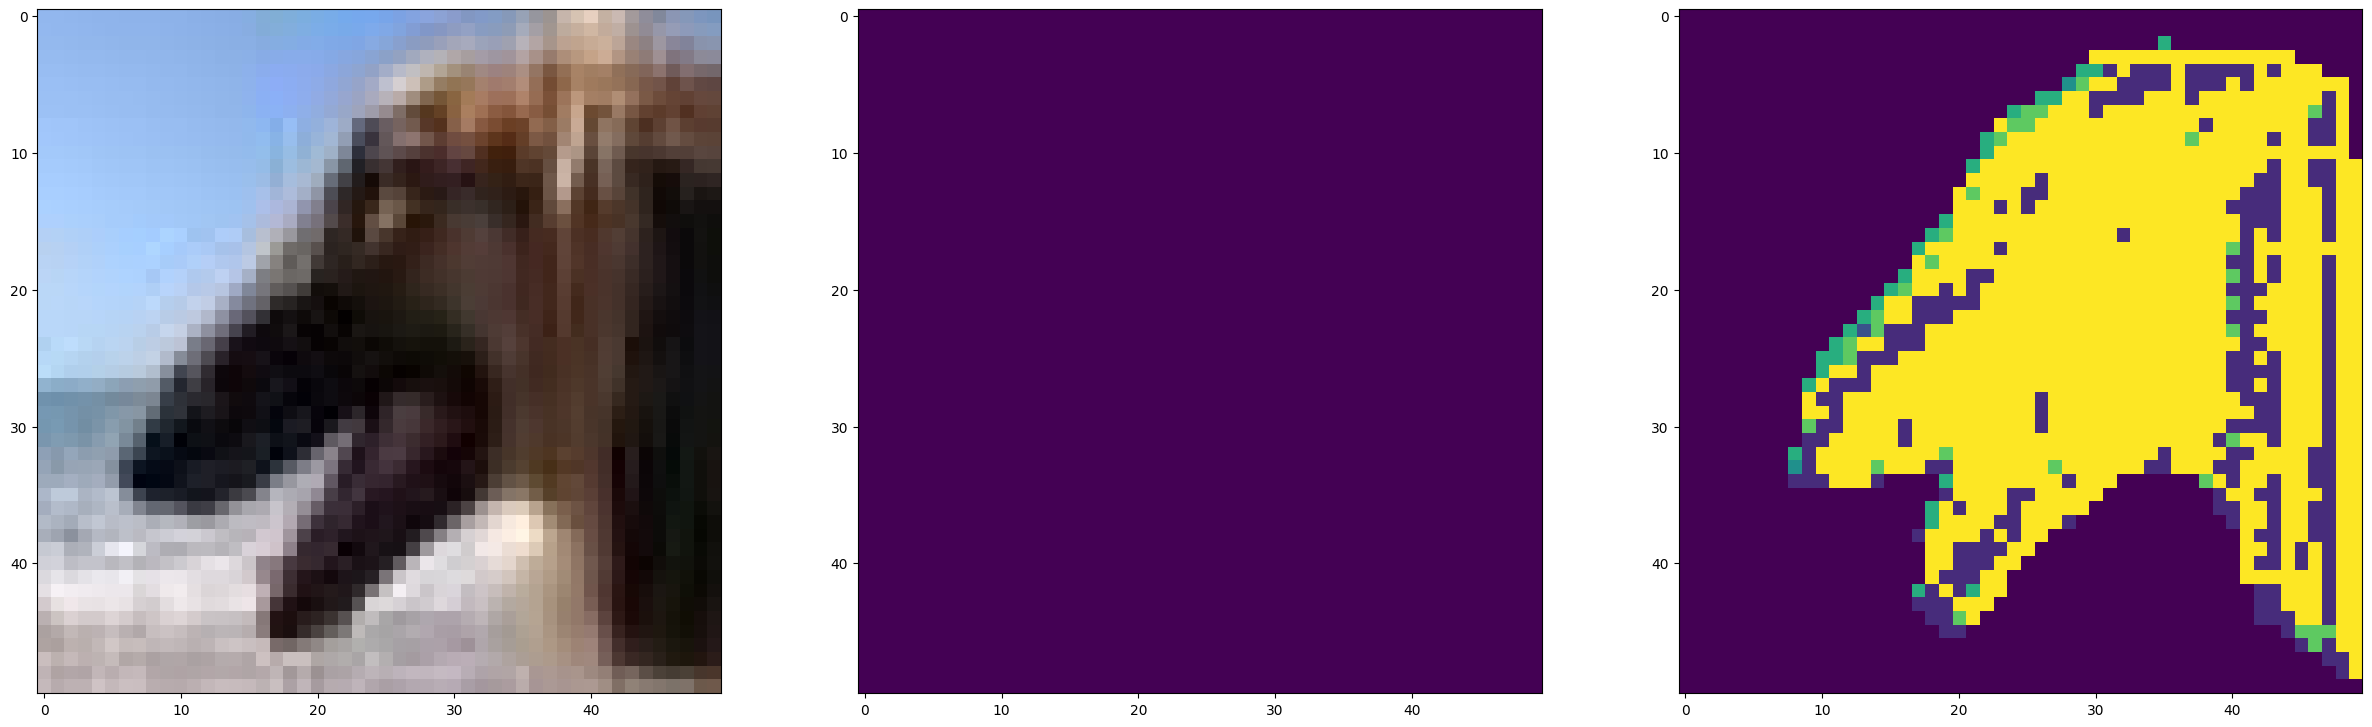

In [15]:
model.eval()
with torch.no_grad():
    output = model(img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img)
binary_mask = np.argmax(mask, axis=-1)  # Selección de la clase con el valor más alto en cada píxel
binary_mask = binary_mask.astype(np.uint8)
ax2.imshow(binary_mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

In [16]:
import os
import numpy as np
from PIL import Image

# Directorio que contiene las subcarpetas con las imágenes en formato PNG
dir_principal = 'DatasetPerros_B_S\\Mask'

# Directorio donde se guardarán los arreglos numpy
dir_destino = 'PerrosDataset2\\mask'

# Crear el directorio de destino si no existe
os.makedirs(dir_destino, exist_ok=True)

# Contador de archivos convertidos
total_archivos = 0

# Obtener la lista de subcarpetas en el directorio principal
subcarpetas = [subcarpeta for subcarpeta in os.listdir(dir_principal) if os.path.isdir(os.path.join(dir_principal, subcarpeta))]

# Iterar sobre las subcarpetas
for subcarpeta in subcarpetas:
    # Directorio que contiene las imágenes PNG de la subcarpeta actual
    dir_imgs = os.path.join(dir_principal, subcarpeta)

    # Obtener la lista de archivos PNG en la subcarpeta actual
    archivos_png = [archivo for archivo in os.listdir(dir_imgs) if archivo.endswith('.png')]

    # Iterar sobre los archivos PNG
    for archivo_png in archivos_png:
        # Ruta completa del archivo PNG
        ruta_png = os.path.join(dir_imgs, archivo_png)

        # Leer la imagen PNG
        imagen = Image.open(ruta_png)

        # Convertir la imagen a un arreglo numpy
        arreglo_numpy = np.array(imagen)

        # Ruta de destino para guardar el arreglo numpy
        ruta_destino = os.path.join(dir_destino, archivo_png.split('.')[0] + '.npy')

        # Guardar el arreglo numpy en el directorio de destino
        np.save(ruta_destino, arreglo_numpy)

        # Incrementar el contador de archivos
        total_archivos += 1

# Mostrar el número total de archivos convertidos
print(f"Se han convertido y guardado {total_archivos} archivos en la carpeta de destino.")


Se han convertido y guardado 8000 archivos en la carpeta de destino.


In [17]:
import os
import numpy as np
from PIL import Image

# Directorio que contiene las subcarpetas con las imágenes en formato PNG
dir_principal = 'DatasetPerros_B_S\\Perros_dataset'

# Directorio donde se guardarán los arreglos numpy
dir_destino = 'PerrosDataset2\\Perros'

# Crear el directorio de destino si no existe
os.makedirs(dir_destino, exist_ok=True)

# Contador de archivos convertidos
total_archivos = 0

# Obtener la lista de subcarpetas en el directorio principal
subcarpetas = [subcarpeta for subcarpeta in os.listdir(dir_principal) if os.path.isdir(os.path.join(dir_principal, subcarpeta))]

# Iterar sobre las subcarpetas
for subcarpeta in subcarpetas:
    # Directorio que contiene las imágenes PNG de la subcarpeta actual
    dir_imgs = os.path.join(dir_principal, subcarpeta)

    # Obtener la lista de archivos PNG en la subcarpeta actual
    archivos_png = [archivo for archivo in os.listdir(dir_imgs) if archivo.endswith('.jpg')]

    # Iterar sobre los archivos PNG
    for archivo_png in archivos_png:
        # Ruta completa del archivo PNG
        ruta_png = os.path.join(dir_imgs, archivo_png)

        # Leer la imagen PNG
        imagen = Image.open(ruta_png)

        # Convertir la imagen a un arreglo numpy
        arreglo_numpy = np.array(imagen)

        # Ruta de destino para guardar el arreglo numpy
        ruta_destino = os.path.join(dir_destino, archivo_png.split('.')[0] + '.npy')

        # Guardar el arreglo numpy en el directorio de destino
        np.save(ruta_destino, arreglo_numpy)

        # Incrementar el contador de archivos
        total_archivos += 1

# Mostrar el número total de archivos convertidos
print(f"Se han convertido y guardado {total_archivos} archivos en la carpeta de destino.")

Se han convertido y guardado 8000 archivos en la carpeta de destino.


In [18]:
import os
import numpy as np
from PIL import Image

# Directorio que contiene las subcarpetas con los arreglos numpy
dir_destino = 'PerrosDataset2\\Perros'

# Obtener la lista de archivos numpy en el directorio de destino
archivos_npy = [archivo for archivo in os.listdir(dir_destino) if archivo.endswith('.npy')]

# Lista para almacenar los arreglos numpy permutados
arreglos_permutados = []

# Iterar sobre los archivos numpy
for archivo_npy in archivos_npy:
    # Ruta completa del archivo numpy
    ruta_npy = os.path.join(dir_destino, archivo_npy)

    # Cargar el arreglo numpy
    arreglo_numpy = np.load(ruta_npy)

    # Permutar las dimensiones a (C, H, W)
    arreglo_numpy_permutado = np.transpose(arreglo_numpy, (2, 0, 1))

    # Agregar el arreglo permutado a la lista
    arreglos_permutados.append(arreglo_numpy_permutado)

# Convertir la lista de arreglos permutados a un solo arreglo numpy
arreglos_permutados = np.array(arreglos_permutados)

# Verificar la forma del arreglo resultante
print("Forma del arreglo resultante:", arreglos_permutados.shape)

Forma del arreglo resultante: (8000, 3, 50, 50)


In [19]:
import os
from pathlib import Path

from pathlib import Path
import os

# Directorio principal que contiene las subcarpetas con las imágenes y máscaras
path = Path('./PerrosDataset2')

# Obtener la lista de rutas de imágenes
imgs = [path/'Perros'/i for i in os.listdir(path/'Perros')]

# Obtener la lista de rutas de máscaras
masks = [path/'mask'/i for i in os.listdir(path/'mask')]

len(imgs), len(masks), type(imgs), type(masks)

(8000, 8000, list, list)

In [20]:
img = np.load(imgs[0])
mask = np.load(masks[0])

img.shape, mask.shape

((50, 50, 3), (50, 50, 3))

In [21]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, n_classes=9):
        self.X = X
        self.y = y
        self.n_classes = n_classes

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        img = np.load(self.X[ix])
        mask = np.load(self.y[ix])
        img = torch.tensor(img).permute(2,0,1)

        # Crear una máscara one-hot para cada clase
        mask_one_hot = np.zeros((self.n_classes, *mask.shape[:2]), dtype=np.float32)
        for i in range(self.n_classes):
            mask_one_hot[i][mask[..., 0] == i] = 1

        # Permutar las dimensiones de la máscara para que sea (C, H, W)
        mask_one_hot = torch.from_numpy(mask_one_hot)
        mask_one_hot = mask_one_hot.permute(0,1,2)

        return img.float(), mask_one_hot

In [22]:
# Tamaño del conjunto de prueba
test_size = 2000

# Dividir el conjunto de datos original en conjuntos de entrenamiento y prueba
imagenes_train = imgs[:-test_size]
masks_train = masks[:-test_size]
imagenes_test = imgs[-test_size:]
masks_test = masks[-test_size:]

# Crear el diccionario de datasets
dataset = {
    'train': Dataset(imagenes_train, masks_train),
    'test': Dataset(imagenes_test, masks_test)
}

# Verificar la longitud de los conjuntos de entrenamiento y prueba
len(dataset['train']), len(dataset['test'])

(6000, 2000)

In [23]:
import torch
from torch.utils.data import DataLoader

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

# Obtén un lote de datos de entrenamiento
imgs, masks = next(iter(dataloader['train']))

# Asegúrate de que las dimensiones sean las correctas
imgs.shape, masks.shape

(torch.Size([16, 3, 50, 50]), torch.Size([16, 9, 50, 50]))

In [24]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [25]:
model = UNet()
hist = fit(model, dataloader, epochs=20),device

test_loss 0.05439 test_iou 0.97559: 100%|██████████| 63/63 [00:12<00:00,  4.89it/s]



Epoch 1/20 loss 0.17196 iou 0.86376 test_loss 0.05439 test_iou 0.97559


test_loss 0.04460 test_iou 0.97623: 100%|██████████| 63/63 [00:01<00:00, 34.93it/s]



Epoch 2/20 loss 0.04137 iou 0.97875 test_loss 0.04460 test_iou 0.97623


test_loss 0.03374 test_iou 0.97871: 100%|██████████| 63/63 [00:01<00:00, 34.79it/s]



Epoch 3/20 loss 0.03215 iou 0.98027 test_loss 0.03374 test_iou 0.97871


test_loss 0.03062 test_iou 0.97912: 100%|██████████| 63/63 [00:01<00:00, 34.78it/s]



Epoch 4/20 loss 0.02895 iou 0.98106 test_loss 0.03062 test_iou 0.97912


test_loss 0.02941 test_iou 0.97998: 100%|██████████| 63/63 [00:01<00:00, 34.87it/s]



Epoch 5/20 loss 0.02678 iou 0.98189 test_loss 0.02941 test_iou 0.97998


test_loss 0.03317 test_iou 0.97902: 100%|██████████| 63/63 [00:01<00:00, 35.14it/s]



Epoch 6/20 loss 0.02532 iou 0.98260 test_loss 0.03317 test_iou 0.97902


test_loss 0.03042 test_iou 0.97982: 100%|██████████| 63/63 [00:01<00:00, 34.99it/s]



Epoch 7/20 loss 0.02393 iou 0.98316 test_loss 0.03042 test_iou 0.97982


test_loss 0.03094 test_iou 0.97964: 100%|██████████| 63/63 [00:01<00:00, 34.55it/s]



Epoch 8/20 loss 0.02264 iou 0.98393 test_loss 0.03094 test_iou 0.97964


test_loss 0.03433 test_iou 0.97883: 100%|██████████| 63/63 [00:01<00:00, 35.47it/s]



Epoch 9/20 loss 0.02123 iou 0.98477 test_loss 0.03433 test_iou 0.97883


test_loss 0.03029 test_iou 0.98035: 100%|██████████| 63/63 [00:01<00:00, 33.18it/s]



Epoch 10/20 loss 0.02022 iou 0.98533 test_loss 0.03029 test_iou 0.98035


test_loss 0.03005 test_iou 0.98015: 100%|██████████| 63/63 [00:01<00:00, 34.82it/s]



Epoch 11/20 loss 0.01930 iou 0.98592 test_loss 0.03005 test_iou 0.98015


test_loss 0.03040 test_iou 0.98042: 100%|██████████| 63/63 [00:01<00:00, 34.63it/s]



Epoch 12/20 loss 0.01862 iou 0.98640 test_loss 0.03040 test_iou 0.98042


test_loss 0.03145 test_iou 0.98006: 100%|██████████| 63/63 [00:01<00:00, 34.36it/s]



Epoch 13/20 loss 0.01754 iou 0.98706 test_loss 0.03145 test_iou 0.98006


test_loss 0.03236 test_iou 0.98024: 100%|██████████| 63/63 [00:01<00:00, 34.96it/s]



Epoch 14/20 loss 0.01676 iou 0.98756 test_loss 0.03236 test_iou 0.98024


test_loss 0.03242 test_iou 0.98030: 100%|██████████| 63/63 [00:01<00:00, 36.47it/s]



Epoch 15/20 loss 0.01608 iou 0.98800 test_loss 0.03242 test_iou 0.98030


test_loss 0.03364 test_iou 0.97921: 100%|██████████| 63/63 [00:01<00:00, 33.54it/s]



Epoch 16/20 loss 0.01585 iou 0.98816 test_loss 0.03364 test_iou 0.97921


test_loss 0.03142 test_iou 0.98028: 100%|██████████| 63/63 [00:01<00:00, 36.60it/s]



Epoch 17/20 loss 0.01524 iou 0.98855 test_loss 0.03142 test_iou 0.98028


test_loss 0.03289 test_iou 0.98002: 100%|██████████| 63/63 [00:01<00:00, 35.17it/s]



Epoch 18/20 loss 0.01474 iou 0.98887 test_loss 0.03289 test_iou 0.98002


test_loss 0.03489 test_iou 0.97974: 100%|██████████| 63/63 [00:01<00:00, 34.83it/s]



Epoch 19/20 loss 0.01408 iou 0.98933 test_loss 0.03489 test_iou 0.97974


test_loss 0.03360 test_iou 0.97925: 100%|██████████| 63/63 [00:01<00:00, 34.80it/s]


Epoch 20/20 loss 0.01406 iou 0.98932 test_loss 0.03360 test_iou 0.97925


In [29]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

AttributeError: 'str' object has no attribute 'keys'

In [30]:
import torchvision

In [31]:
encoder = torchvision.models.resnet18(pretrained=True)
encoder

c:\Users\Diego-pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Diego-pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Diego-pc/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:07<00:00, 6.53MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=9, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True)
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = torch.tensor(x.clone())
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [33]:
model = UNetResnet()
output = model(torch.randn((10,3,50,50)))
output.shape

C:\Users\Diego-pc\AppData\Local\Temp\ipykernel_23048\952178036.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


torch.Size([10, 9, 50, 50])

In [34]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=15)

  0%|          | 0/375 [00:00<?, ?it/s]C:\Users\Diego-pc\AppData\Local\Temp\ipykernel_23048\952178036.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())
test_loss 0.07743 test_iou 0.98132: 100%|██████████| 63/63 [00:02<00:00, 26.22it/s]



Epoch 1/15 loss 0.22261 iou 0.92146 test_loss 0.07743 test_iou 0.98132


test_loss 0.03887 test_iou 0.98159: 100%|██████████| 63/63 [00:02<00:00, 26.80it/s]



Epoch 2/15 loss 0.04868 iou 0.98364 test_loss 0.03887 test_iou 0.98159


test_loss 0.02912 test_iou 0.98325: 100%|██████████| 63/63 [00:02<00:00, 27.53it/s]



Epoch 3/15 loss 0.02932 iou 0.98535 test_loss 0.02912 test_iou 0.98325


test_loss 0.02991 test_iou 0.98225: 100%|██████████| 63/63 [00:02<00:00, 27.51it/s]



Epoch 4/15 loss 0.02303 iou 0.98650 test_loss 0.02991 test_iou 0.98225


test_loss 0.02735 test_iou 0.98204: 100%|██████████| 63/63 [00:02<00:00, 25.65it/s]



Epoch 5/15 loss 0.01968 iou 0.98739 test_loss 0.02735 test_iou 0.98204


test_loss 0.02512 test_iou 0.98369: 100%|██████████| 63/63 [00:02<00:00, 27.46it/s]



Epoch 6/15 loss 0.01762 iou 0.98815 test_loss 0.02512 test_iou 0.98369


test_loss 0.02390 test_iou 0.98420: 100%|██████████| 63/63 [00:02<00:00, 26.19it/s]



Epoch 7/15 loss 0.01608 iou 0.98873 test_loss 0.02390 test_iou 0.98420


test_loss 0.02437 test_iou 0.98375: 100%|██████████| 63/63 [00:02<00:00, 26.18it/s]



Epoch 8/15 loss 0.01457 iou 0.98959 test_loss 0.02437 test_iou 0.98375


test_loss 0.02633 test_iou 0.98354: 100%|██████████| 63/63 [00:02<00:00, 27.55it/s]



Epoch 9/15 loss 0.01379 iou 0.98993 test_loss 0.02633 test_iou 0.98354


test_loss 0.02599 test_iou 0.98345: 100%|██████████| 63/63 [00:02<00:00, 27.53it/s]



Epoch 10/15 loss 0.01335 iou 0.99015 test_loss 0.02599 test_iou 0.98345


test_loss 0.02763 test_iou 0.98306: 100%|██████████| 63/63 [00:02<00:00, 27.29it/s]



Epoch 11/15 loss 0.01291 iou 0.99038 test_loss 0.02763 test_iou 0.98306


test_loss 0.02732 test_iou 0.98337: 100%|██████████| 63/63 [00:02<00:00, 26.21it/s]



Epoch 12/15 loss 0.01252 iou 0.99059 test_loss 0.02732 test_iou 0.98337


test_loss 0.02635 test_iou 0.98367: 100%|██████████| 63/63 [00:02<00:00, 26.38it/s]



Epoch 13/15 loss 0.01155 iou 0.99124 test_loss 0.02635 test_iou 0.98367


test_loss 0.02990 test_iou 0.98368: 100%|██████████| 63/63 [00:02<00:00, 25.85it/s]



Epoch 14/15 loss 0.01078 iou 0.99177 test_loss 0.02990 test_iou 0.98368


test_loss 0.02932 test_iou 0.98350: 100%|██████████| 63/63 [00:02<00:00, 25.77it/s]


Epoch 15/15 loss 0.01021 iou 0.99217 test_loss 0.02932 test_iou 0.98350


In [89]:
torch.save(model.state_dict(), 'modelo_entrenado_perrosSeg.pth')

C:\Users\Diego-pc\AppData\Local\Temp\ipykernel_23048\952178036.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


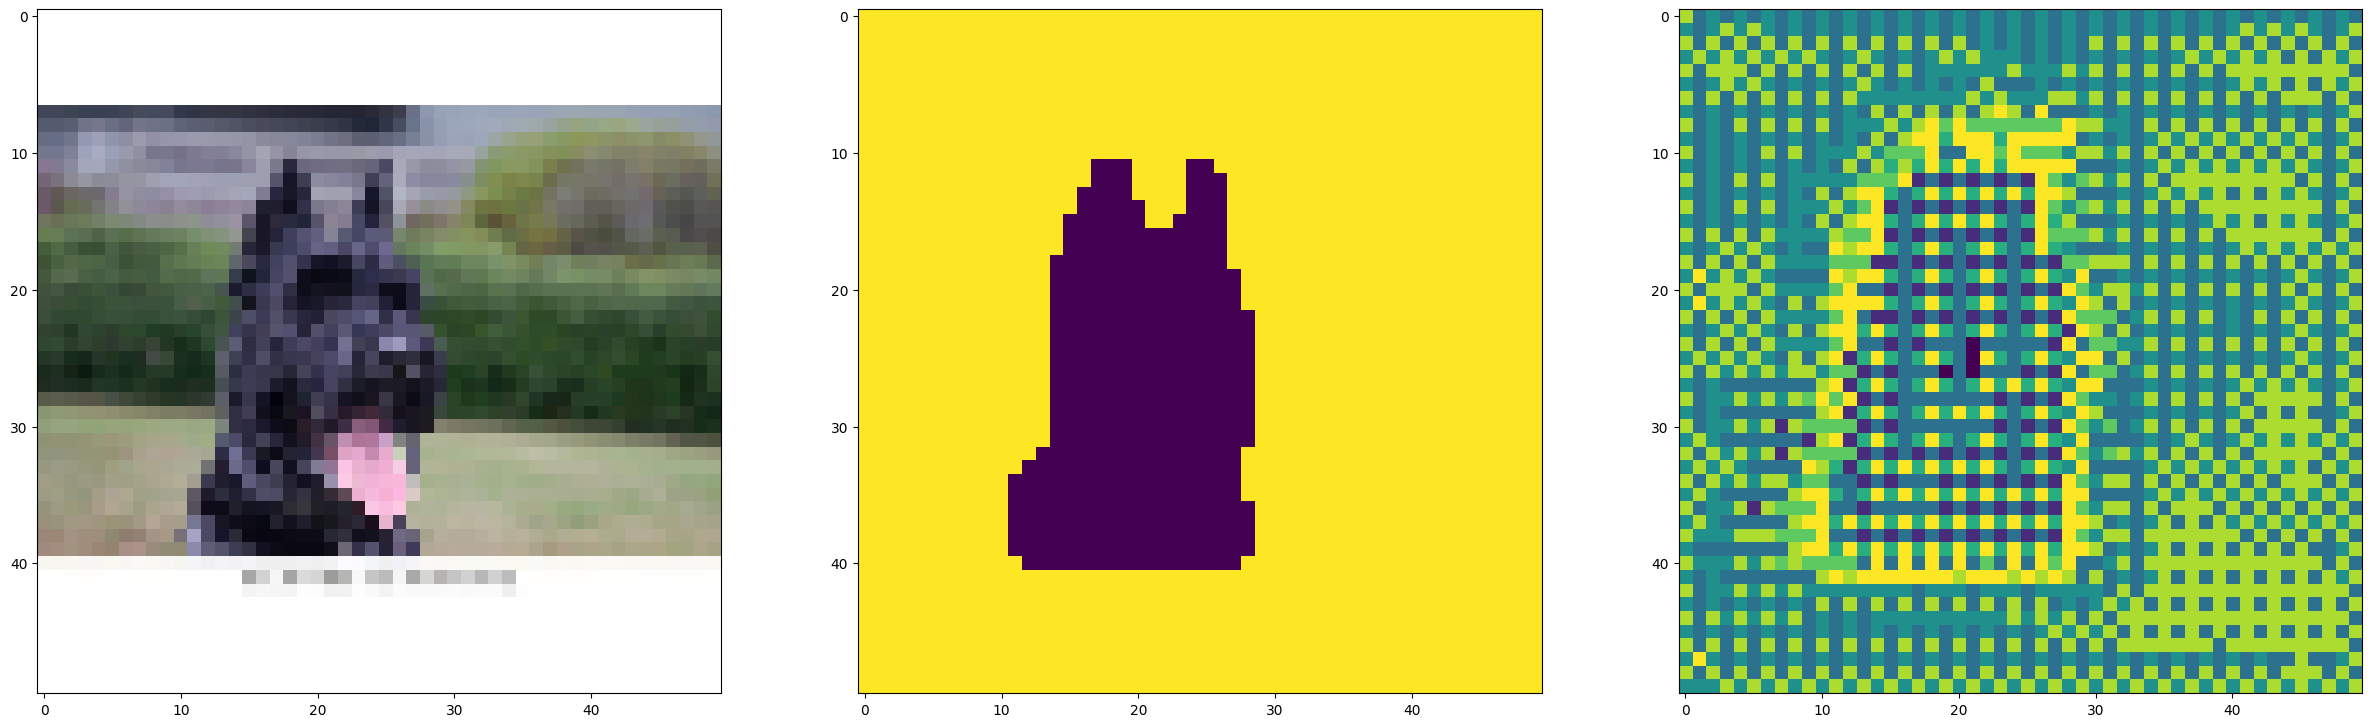

In [83]:
import random

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    output = model(img.unsqueeze(0).to(device))[0]
    output = output*(-1)
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.permute(1,2,0)/255.)
ax2.imshow(torch.argmax(mask*(-1), axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

C:\Users\Diego-pc\AppData\Local\Temp\ipykernel_23048\952178036.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


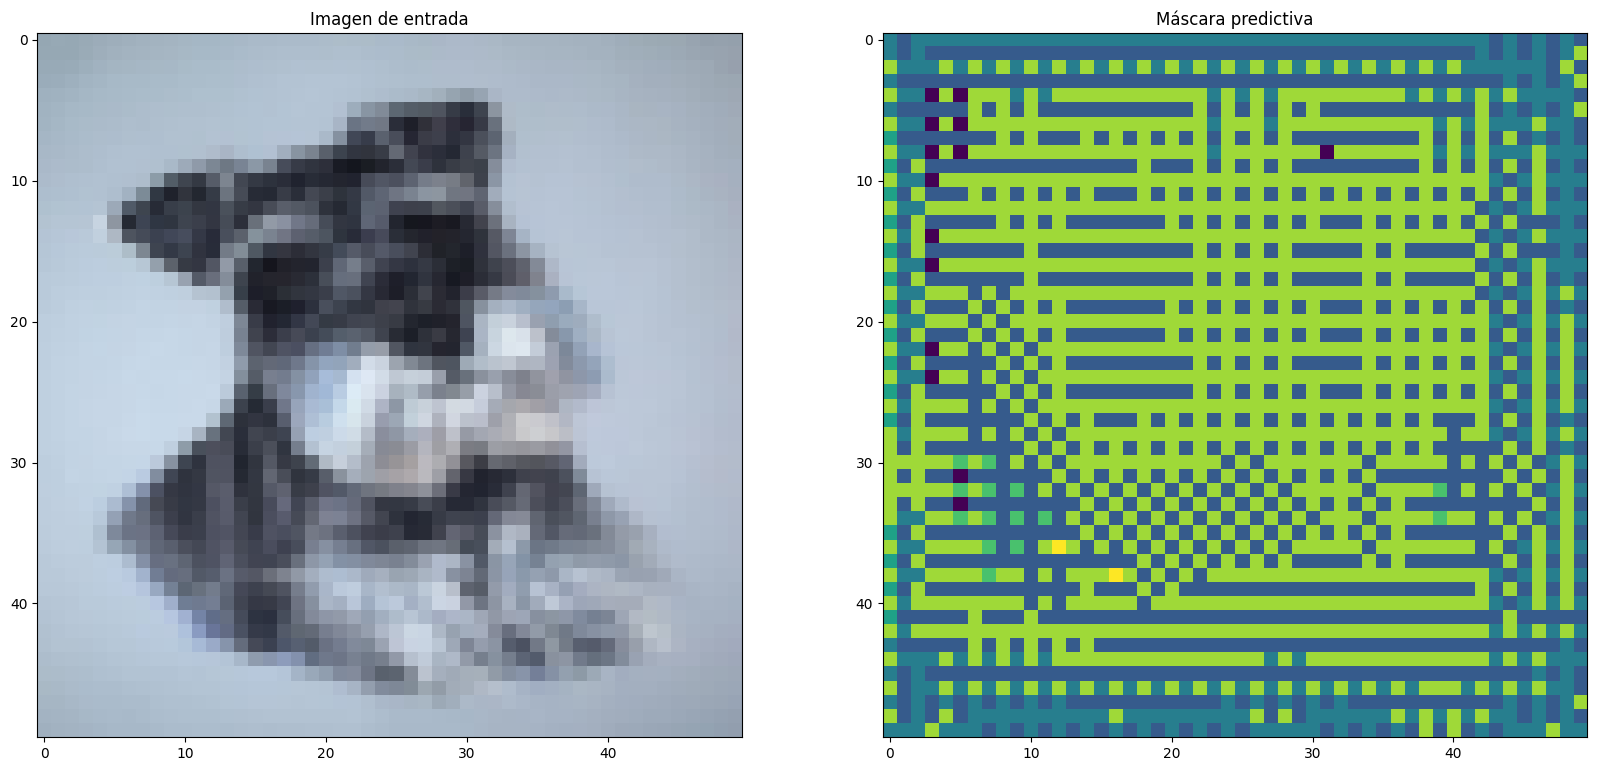

In [84]:




from PIL import Image
import torchvision.transforms as transforms

# Abrir la imagen
image_path = "perro_prueba.jpg"  # Reemplaza con la ruta de tu imagen
image = Image.open(image_path)

# Redimensionar la imagen a 50x50 píxeles
resize = transforms.Resize((50, 50))
image = resize(image)

# Convertir la imagen a tensor y aplicar transformaciones adicionales si es necesario
transform = transforms.Compose([
    transforms.ToTensor(),
    # Agrega otras transformaciones aquí si es necesario
])
image = transform(image)

# Utilizar el modelo para hacer predicciones
model.eval()
with torch.no_grad():
    input_image = image.unsqueeze(0).to(device)
    output = model(input_image)
    output = output * (-1)
    pred_mask = torch.argmax(output, axis=1).squeeze().cpu().numpy()

# Visualizar la imagen y la máscara predictiva
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image.permute(1, 2, 0))  # Mostrar la imagen
ax1.set_title("Imagen de entrada")
ax2.imshow(pred_mask)  # Mostrar la máscara predictiva
ax2.set_title("Máscara predictiva")
plt.show()

In [88]:
import torch.nn.functional as F
import torchvision.transforms.functional as TF

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=9, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True)
        if in_ch != 3:
            self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)
        self.dropout = torch.nn.Dropout2d(p=0.5)  # Capa de dropout con probabilidad de 0.5

    def forward(self, x):
        x_in = torch.tensor(x.clone())
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.dropout(x)  # Aplicar dropout
        x = self.out(x, x_in)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.argmax(y_hat, dim=1)
        acc = (pred == y).float().mean()
        return {"val_loss": loss, "val_acc": acc}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [90]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=15)

c:\Users\Diego-pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Diego-pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/375 [00:00<?, ?it/s]C:\Users\Diego-pc\AppData\Local\Temp\ipykernel_23048\3218699833.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1/15 loss 0.22957 iou 0.89444 test_loss 0.07833 test_iou 0.98162


test_loss 0.04006 test_iou 0.98230: 100%|██████████| 63/63 [00:02<00:00, 26.61it/s]



Epoch 2/15 loss 0.05191 iou 0.98336 test_loss 0.04006 test_iou 0.98230


test_loss 0.03073 test_iou 0.98349: 100%|██████████| 63/63 [00:02<00:00, 27.33it/s]



Epoch 3/15 loss 0.03085 iou 0.98502 test_loss 0.03073 test_iou 0.98349


test_loss 0.02798 test_iou 0.98304: 100%|██████████| 63/63 [00:02<00:00, 27.60it/s]



Epoch 4/15 loss 0.02445 iou 0.98596 test_loss 0.02798 test_iou 0.98304


test_loss 0.02807 test_iou 0.98283: 100%|██████████| 63/63 [00:02<00:00, 27.23it/s]



Epoch 5/15 loss 0.02066 iou 0.98701 test_loss 0.02807 test_iou 0.98283


test_loss 0.02721 test_iou 0.98235: 100%|██████████| 63/63 [00:02<00:00, 27.13it/s]



Epoch 6/15 loss 0.01875 iou 0.98756 test_loss 0.02721 test_iou 0.98235


test_loss 0.02540 test_iou 0.98423: 100%|██████████| 63/63 [00:02<00:00, 27.66it/s]



Epoch 7/15 loss 0.01677 iou 0.98844 test_loss 0.02540 test_iou 0.98423


test_loss 0.02645 test_iou 0.98265: 100%|██████████| 63/63 [00:02<00:00, 27.79it/s]



Epoch 8/15 loss 0.01580 iou 0.98885 test_loss 0.02645 test_iou 0.98265


test_loss 0.02561 test_iou 0.98245: 100%|██████████| 63/63 [00:02<00:00, 27.64it/s]



Epoch 9/15 loss 0.01498 iou 0.98924 test_loss 0.02561 test_iou 0.98245


test_loss 0.02653 test_iou 0.98328: 100%|██████████| 63/63 [00:02<00:00, 27.54it/s]



Epoch 10/15 loss 0.01492 iou 0.98920 test_loss 0.02653 test_iou 0.98328


test_loss 0.02708 test_iou 0.98232: 100%|██████████| 63/63 [00:02<00:00, 27.72it/s]



Epoch 11/15 loss 0.01356 iou 0.99004 test_loss 0.02708 test_iou 0.98232


test_loss 0.02796 test_iou 0.98348: 100%|██████████| 63/63 [00:02<00:00, 27.53it/s]



Epoch 12/15 loss 0.01317 iou 0.99024 test_loss 0.02796 test_iou 0.98348


test_loss 0.02701 test_iou 0.98371: 100%|██████████| 63/63 [00:02<00:00, 27.47it/s]



Epoch 13/15 loss 0.01227 iou 0.99083 test_loss 0.02701 test_iou 0.98371


test_loss 0.02656 test_iou 0.98364: 100%|██████████| 63/63 [00:02<00:00, 27.68it/s]



Epoch 14/15 loss 0.01183 iou 0.99112 test_loss 0.02656 test_iou 0.98364


test_loss 0.02854 test_iou 0.98314: 100%|██████████| 63/63 [00:02<00:00, 27.96it/s]


Epoch 15/15 loss 0.01182 iou 0.99109 test_loss 0.02854 test_iou 0.98314


In [92]:
torch.save(model.state_dict(), 'modelo_entrenado_perrosSeg2outover.pth')

C:\Users\Diego-pc\AppData\Local\Temp\ipykernel_23048\3218699833.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


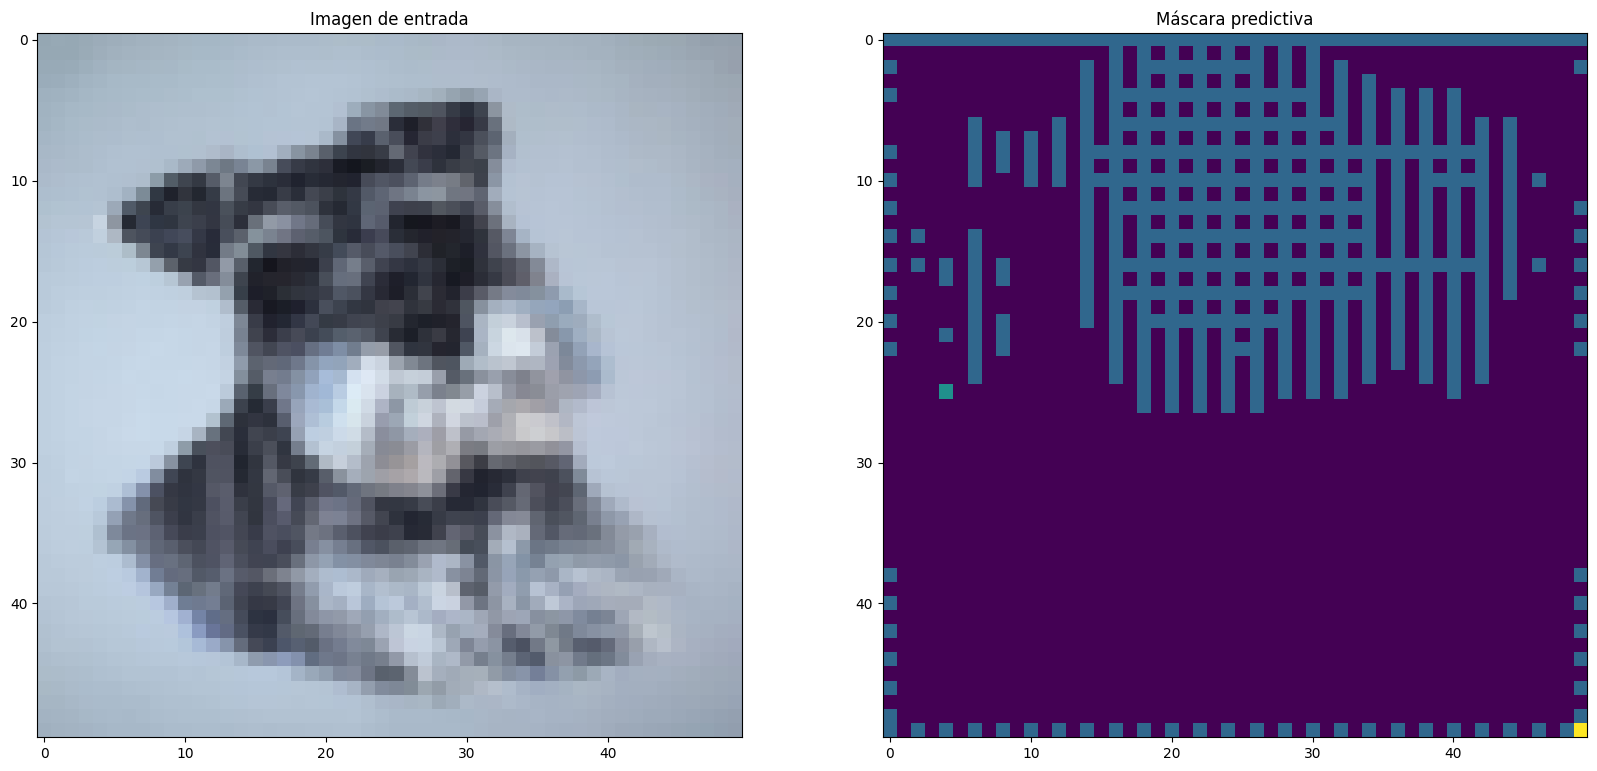

In [91]:
from PIL import Image
import torchvision.transforms as transforms

# Abrir la imagen
image_path = "perro_prueba.jpg"  # Reemplaza con la ruta de tu imagen
image = Image.open(image_path)

# Redimensionar la imagen a 50x50 píxeles
resize = transforms.Resize((50, 50))
image = resize(image)

# Convertir la imagen a tensor y aplicar transformaciones adicionales si es necesario
transform = transforms.Compose([
    transforms.ToTensor(),
    # Agrega otras transformaciones aquí si es necesario
])
image = transform(image)

# Utilizar el modelo para hacer predicciones
model.eval()
with torch.no_grad():
    input_image = image.unsqueeze(0).to(device)
    output = model(input_image)
    output = output * (-1)
    pred_mask = torch.argmax(output, axis=1).squeeze().cpu().numpy()

# Visualizar la imagen y la máscara predictiva
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image.permute(1, 2, 0))  # Mostrar la imagen
ax1.set_title("Imagen de entrada")
ax2.imshow(pred_mask)  # Mostrar la máscara predictiva
ax2.set_title("Máscara predictiva")
plt.show()